In [2]:
!pip install scikit-learn-intelex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 MB 7.8 MB/s eta 0:00:00


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


1) Number of columns:  53
2) Number of rows:  180519
3) Total number of data-points:  9567507
4) Count of Numerical Features:  29
5) Count of Categorical Features:  24
Percentage of Total Missing Values:  3.51 %
Missing Value Estimation:
The Feature Customer Lname has 8 missing values
The Feature Customer Zipcode has 3 missing values
The Feature Order Zipcode has 155679 missing values
The Feature Product Description has 180519 missing values
The r-squared score of the model is  0.9951958803331444
The mean squared error is 0.012671726124529138
The mean absolute error is 0.011951584311987591
1) The accuracy of the risk predictor model is:  0.9761522269000664
2) The AUROC score is:  0.9791343544009306
3) Classification metrics:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15472
           1       1.00      0.96      0.98     20632

    accuracy                           0.98     36104
   macro avg       0.97      0.98      0.98    

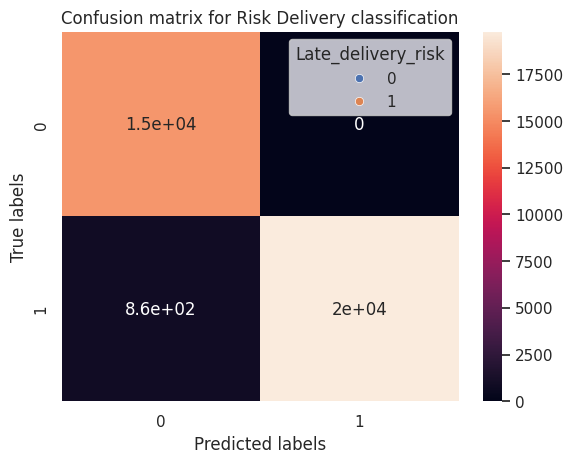

In [4]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix

# Intel oneAPI Imports
from sklearnex import patch_sklearn

# Patch scikit-learn to use Intel's oneAPI optimizations
patch_sklearn()

# Load data
data = pd.read_csv('DataCoSupplyChainDataset.csv', header=0, encoding='unicode_escape')

# Display options
pd.set_option('display.max_columns', None)
data.head()

# Basic data info
def data_info(data):
    print('1) Number of columns: ', data.shape[1])
    print('2) Number of rows: ', data.shape[0])
    print('3) Total number of data-points: ', data.size)
    numerical_features = [f for f in data.columns if data[f].dtypes != 'O']
    print('4) Count of Numerical Features: ', len(numerical_features))
    cat_features = [c for c in data.columns if data[c].dtypes == 'O']
    print('5) Count of Categorical Features: ', len(cat_features))

data_info(data)

# Missing values check
def features_with_missing_values(data):
    x = data.isnull().sum().sum() / (data.shape[0] * data.shape[1]) * 100
    print('Percentage of Total Missing Values: ', round(x, 2), '%')
    print('Missing Value Estimation:')
    for i in data.columns:
        if data[i].isna().sum() > 0:
            print('The Feature', i, 'has', str(data[i].isna().sum()), 'missing values')

features_with_missing_values(data)

# Target value analysis
sns.set()
sns.scatterplot(x="Days for shipment (scheduled)", y="Days for shipping (real)", hue="Late_delivery_risk", data=data)

# Shipment and finance data selection
shipment_features = ['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Late_delivery_risk', 'Benefit per order',
                     'Sales per customer', 'Latitude', 'Longitude', 'Shipping Mode', 'Order Status', 'Order Region',
                     'Order Country', 'Order City', 'Market', 'Delivery Status']
shipment = data[shipment_features]
shipment.head()

finance_features = ['Benefit per order', 'Sales per customer', 'Order Item Discount', 'Order Item Discount Rate',
                    'Order Item Product Price', 'Order Item Profit Ratio']
finance = data[finance_features]
finance.head()

# Convert categorical features to datetime
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])
data['shipping_date'] = pd.to_datetime(data['shipping date (DateOrders)'])

# Extract year, month, day
data['order_year'] = pd.DatetimeIndex(data['order_date']).year
data['order_month'] = pd.DatetimeIndex(data['order_date']).month
data['order_day'] = pd.DatetimeIndex(data['order_date']).day
data['shipping_year'] = pd.DatetimeIndex(data['shipping_date']).year
data['shipping_month'] = pd.DatetimeIndex(data['shipping_date']).month
data['shipping_day'] = pd.DatetimeIndex(data['shipping_date']).day

# Dataset with new features
new_dataset_features = ['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Late_delivery_risk', 'Benefit per order',
                        'Sales per customer', 'Latitude', 'Longitude', 'Shipping Mode', 'Order Status', 'Order Region',
                        'Order Country', 'Order City', 'Market', 'Delivery Status', 'order_day', 'order_month', 'order_year',
                        'shipping_day', 'shipping_month', 'shipping_year']
new_data = data[new_dataset_features]

# One-Hot encoding categorical variables
model_data = pd.get_dummies(new_data)
model_data.shape

# Defining features and target variables
x = model_data.drop(['Days for shipping (real)', 'Days for shipment (scheduled)'], axis=1)
y = model_data[['Days for shipping (real)', 'Days for shipment (scheduled)']]
x.shape, y.shape

# Train-test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.20)

# Model training with Intel-optimized DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(x_train, y_train)

# Predictions
pred = model.predict(x_test)

# Performance metrics
def metrics(y_test, pred):
    a = r2_score(y_test, pred)
    b = mean_squared_error(y_test, pred)
    c = mean_absolute_error(y_test, pred)
    print('The r-squared score of the model is ', a)
    print('The mean squared error is', b)
    print('The mean absolute error is', c)

metrics(y_test, pred)

# Convert prediction to DataFrame
Prediction = pd.DataFrame(pred)
prediction = Prediction.rename(columns={0: 'Fastest_shipment', 1: 'Avg_shipment'})
prediction.head()

# Statistical modeling
prediction['risk'] = np.where(prediction['Avg_shipment'] >= prediction['Fastest_shipment'], 0, 1)
prediction.head()

# Risk evaluation
l = prediction['risk']
m = x_test['Late_delivery_risk']
l.shape, m.shape

# Risk evaluation metrics
def evaluation_risk_factor(l, m):
    print('1) The accuracy of the risk predictor model is: ', accuracy_score(l, m))
    print('2) The AUROC score is: ', roc_auc_score(l, m))
    print('3) Classification metrics:')
    print(classification_report(l, m))
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(l, m), annot=True, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion matrix for Risk Delivery classification')

evaluation_risk_factor(l, m)